# Notes on SwAV

## Content
1. Why SwAV?
2. SwAV Loss
3. SwAV Computing Codes Online
4. Sinkhorn-Knopp Algorithm
5. Why SwAV Works

# Why SwAV?

## About

1. SwAV (**S**wapping **A**ssignments between multiple **Views** of the same image) is introduced in Unsupervised Learning of Visual Features by Contrasting Cluster Assignments (Caron et al. NeurIPS 2021).

2. SwAV achieves 75.3% top-1 accuracy on ImageNet with ResNet-50 for linear models trained on frozen features, which is only 1.2% difference from the supervised method (76.5%), closing the gap between unsupervised and supervised learning representation of visual features.

3. SwAV is an unsupervised contrastive learning method that simultaneously clusters the data while enforcing consistency between cluster assignments produced for different augmentations (or "views") of the same image, and uses a "swapped" prediction mechanism by predicting the code of a view from the representation of another view.

4. SwAV can be trained with large and small batches and can scale to unlimited amounts of data. SwAV also does not require a large memory bank or a special momentum network, therefore is more memory efficient than previous contrastive methods.

5. SwAV also introduces a new augmentation "multi-crop" that increases the number of views with no computational or memory overhead.

## Motive

1. Recent contrastive learning methods for unsupervised visual representation learning uses:
  1. A contrastive loss that compares pairs of images to push away semantically different images while pulling together semantically similar images
  2. Image augmentations that define invariances encoded in the features.
2. Instance discrimination (contrasting instances of image views) is not practical for all pairwise comparisons on a large dataset. Clustering-based methods thus approximate task by discriminating between clusters images with similar features instead of individual images.
3. However, current clustering-based methods are computationally inefficient.
3. Therefore, SwAV proposes a scalable, online clustering-based method, and a "swapped" prediction problem to learn visual features.

Reference: [Unsupervised Learning of Visual Features by Contrasting Cluster Assignments](https://arxiv.org/abs/2006.09882) (Caron et al. NeurIPS 2021)

# SwAV Loss

SwAV can be interpreted as contrasting between multiple images views by comparing cluster assignments instead of their features. SwAV does this by computing a code from one view and predicting that code from the other view.

1. Given image $x$, augment and obtain the 2 views' image features $z_t, z_s$.

2. Match image features $z_t, z_s$ to prototypes $\{c_1,...,c_k\}$ to compute codes $q_t,q_s$.

3. Set up the "swapped" prediction problem with the loss function: $$ L(z_t,z_s)= l(z_t,q_s) + l(z_s,q_t) $$ where $l(z,q) = \sum_k q_s^{(k)}log\,p_t^{(k)}$ measures fit between features $z$ and code $q$, where $p_t^{(k)} = \frac{exp(\frac{1}{\tau}z_t^\intercal c_k)}{\sum_{k'}exp(\frac{1}{\tau}z_t^\intercal c_{k'})}$.

4. Taking this loss over all images and pairs of data augmentations lead to: $$ -\frac{1}{N}\sum_{n=1}^N \sum_{s,t\sim T} [\frac{1}{\tau}z_{nt}^\intercal Cq_{ns} + \frac{1}{\tau}z_{ns}^\intercal Cq_{nt} - log\sum_{k=1}^K exp(\frac{z_{nt}^\intercal}{\tau}) - log\sum_{k=1}^K exp(\frac{z_{ns}^\intercal}{\tau})] $$

5. This loss is minimized with respect to prototypes $C$ and parameters $\theta$ of image encoder $f_\theta$.

# SwAV Computing Codes Online

SwAV clusters instances to the prototypes $C$, and compute codes using prototypes $C$ such that all instances are equally partitioned by the prototypes.

1. Given image features $Z = [z_1,...,z_B]$, map them to prototypes $C = [c_1,...,c_k]$, where the mapping (codes) is denoted by $Q = [q_1,...,q_B]$.

2. $Q$ is optimized to maximized similarity between features and prototypes using $$ max_{Q\in \mathcal{Q}} Tr(Q^\intercal C^\intercal Z) + \varepsilon H(Q) $$ where $H(Q) = -\sum_{i,j}Q_{ij}log\,Q_{ij}$ is the entropy function.

3. $C^\intercal Z = \begin{bmatrix} c_1 \\ c_2 \end{bmatrix} \begin{bmatrix} z_1 & z_2 & z_3 \end{bmatrix} = \begin{bmatrix} c_1z_1 & c_1z_2 & c_1z_3 \\ c_2z_1 & c_2z_2 & c_2z_3 \end{bmatrix}$

4. $Tr(\begin{bmatrix} q_{11} & q_{21} \\ q_{12} & q_{22} \\ q_{13} & q_{23} \end{bmatrix}\begin{bmatrix} C^\intercal Z \end{bmatrix}) = q_{11}c_1z_1 + q_{21}c_2z_1 + q_{12}c_1z_2 + q_{22}c_2z_2 + q_{13}c_1z_3 + q_{23}c_3z_3$

5. $Q$ is a range of continuous values between 0 and 1. $Q$ is 0 for the general case and close to 1 when a $z$ representation is close to its prototype vector $C$. This is because optimizing $Q$ to maximise the trace $Tr(Q^\intercal C^\intercal Z)$ results in the dot products where $c$ and $z$ are close together will take a bigger value. The values of $q$ will try to be maximised.

6. However, the maximization of values of $q$ are regularized by $H(Q) = -\sum_{i,j}Q_{ij}log\,Q_{ij}$. The closer $q_{ij}$ is to 0, the bigger the $log\,Q_{ij}$ value will be, and the maximum of $Q_{ij}log\,Q_{ij}$ will be in the middle of 0 and 1. A higher entropy will give a more homogenous distribution of $Q$.

7. $Q$ is optimized using the Sinkhorn-Knopp algorithm.

Reference: [SwAV Loss Deep Dive by Ananya Harsh Jha](https://www.youtube.com/watch?v=M_DgS3XGeJc&ab_channel=PyTorchLightning)

# Sinkhorn-Knopp Algorithm

The goal of optimal transport is to transform one probability distribution into another with minimal cost.
1. For example, let us allocate desserts to people according to preferences while constraining portion sizes.
2. Let $r = (3,3,3,4,2,2,2,1)$, the portion size of dessert each person can eat (n-dimensional).
3. Let $c = (4,2,6,4,4)$, the amount of each dessert available (m-dimensional).
4. Let $U(r,c)=\{P\in \mathbb{R}_{>0}^{n\times m} |P\textbf{1}_m=r, P^\intercal\textbf{1}_n=c \}$ be the set of positive $n\times m$ matrices for which rows sum to $r$ and columns sum to $c$, which is the set of ways of allocating desserts to the people.
5. Let $M$ be the $(n\times m)$ cost (negative preference) matrix.
6. The optimal transport problem is formally posed as $$d_M(r,c) = min_{P\in U(r,c)} \sum_{i,j} P_{ij}M_{ij}$$ the optimal transport between $r$ and $c$.
7. The Sinkhorn distance is $$d_M(r,c) = min_{P\in U(r,c)} \sum_{i,j} P_{ij}M_{ij}-\frac{1}{\lambda}h(P)$$ where $h(P)=-\sum_{i,j}P_{ij}$ is the information entropy of $P$ that acts as regularization.
8. The Sinkhorn-Knopp algorithm is an efficient method to obtain the optimal distribution matrix $P_\lambda^*$ and the associated $d_M^\lambda(r,c)$ based on the fact that elements of the optimal matrix are of the form $$ (P_\lambda^*)_{ij} = \alpha_i\beta_je^{-\lambda M_{ij}}$$ with $\alpha_1,...,\alpha_n$ and $\beta_1,...,\beta_n$ are constants to ensure rows and columns sum to $r$ and $c$ respectively.
9. The Sinkhorn-Knopp algorithm is basically
  1. Initialise $P_\lambda = e^{-\lambda M}$.
  2. Repeat 3-4 until convergence:
  3. Scale the rows such that row sums match $r$.
  4. Scale the columns such that column sums match $c$.

Reference: [Notes on Optimal Transport by Michiel Stock](https://michielstock.github.io/posts/2017/2017-11-5-OptimalTransport/)

In [52]:
import numpy as np
import pandas as pd

r = np.array([3,3,3,4,2,2,2,1])  # amount each of the 7 people can eat
c = np.array([4,2,6,4,4])  # portions of the 5 desserts available
M = np.array([[2,2,1,0,0],
              [0,-2,-2,-2,2],
              [1,2,2,2,-1],
              [2,1,0,1,-1],
              [0.5,2,2,1,0],
              [0,1,1,1,-1],
              [-2,2,2,1,1],
              [2,1,2,1,-1]])  # (n x m) preferences matrix
M = -M  # converting preferences to cost

In [103]:
"""
Sinkhorn-Knopp Algorithm
"""
def sinkhorn_knopp(M, r, c, lam):
  n, m = M.shape
  P = np.exp(- lam * M)
  P /= P.sum()
  u = np.zeros(n)

  while np.max(np.abs(u - P.sum(1))) > 1e-8:  
    u = P.sum(1)
    P *= (r / u).reshape((-1,1))
    P *= (c / P.sum(0)).reshape((1,-1))
  return P

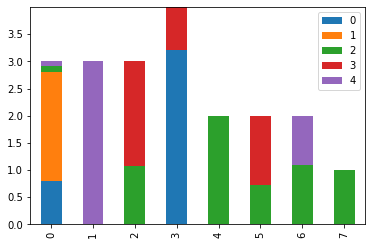

In [105]:
P = sinkhorn_knopp(M, r, c, lam=10)

pd.DataFrame(P).plot.bar(stacked=True)
plt.show()

# Why SwAV Works

1. SwAV authors re-implemented and improveed previous clustering-based models to compare with SwAV.

2. DeepCluster-v2 obtains 75.2% top-1 accuracy on ImageNet versus 75.3% for SwAV.

3. However, DeepCluster-v2 is not online, making it impractical for extremely large datasets, e.g. billion scale trainings which sometimes use only a single training epoch.

4. As seen, SwAV can work online and therefore can scale better to unlimited amounts of data.